This notebook plots the main mathematical quantities in the ice-shelf perturbation problem,
which is described in much more detail in the notes. In words, we consider perturbations to an ice-shelf
equilbrium state (uniform flow the $x$ direction) that are driven by melting or freezing at the base (ice-ocean interface).

Briefly, all lengths are scaled by the ice thickness $H$ and times are scaled by the charactersitc relaxation time
$t_r = 2\eta/(\rho_\mathrm{i}gH)$.

The problem is succintly stated as the differential equation
$$\frac{\partial \pmb{y}}{\partial t} = \mathsf{A}\pmb{y} + \pmb{b}. $$ 
Here, the solution is the vector 
$$ \pmb{y} = [\widehat{h},\widehat{s}]^T $$
that contains the Fourier-transformed upper-surface elevation $h$ and lower-surface elevation $s$ perturbations. 
The Fourier transforms are taken with respect to the horizontal coordinates $(x,y)$. Below, $k$ denotes the magnitude
of the wavevector $\pmb{k}=[k_x,k_y]^T$.
The forcing vector 
$$\pmb{b}=[0,\widehat{m}]^T$$
contains the Fourier-transformed basal melting (or freezing) rate $m$. Finally, the coefficient matrix
is defined by $$\mathsf{A} = -\begin{bmatrix}
ik_x\alpha + \mathsf{R} & \delta \mathsf{B} \\
 \mathsf{B} & ik_x\alpha + \delta \mathsf{R}
\end{bmatrix},$$
where $\delta = \rho_\mathrm{w}/\rho_\mathrm{i}-1$ is the flotation factor, $\mathsf{R}(k)$ is a topographic relaxation function, $\mathsf{B}(k)$ describes transfer of buoyancy forcing between the upper and lower surfaces,
and $\alpha$ is advection from the background flow. Expressions for the buoyancy and relaxation functions in terms of the wavevector magnitude $k$
are provided in the notes.

In this notebook, we will be looking at: 

1. the properties of $\mathsf{R}$ and $\mathsf{B}$, 
2. the eigenvalues and eigenvectors of $\mathsf{A}$, 
3. the integral kernels $\mathsf{K}_h$ and $\mathsf{K}_s$ that are related to the
elevation solutions via $$\widehat{h} = \widehat{m}*\mathsf{K}_h \\
\widehat{s} = \widehat{m}*\mathsf{K}_s $$
   where $*$ denotes convolution over time.
4. A free-space Green's function (AKA fundamental solution) for the steady surface-elevation anomaly produced by a line source basal melting (or freezing) anomaly

First we import all of the relevant functions and modules:

In [1]:
# add path to code
import sys
sys.path.insert(0, '../code')
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import params as p
from kernel_fcns import R,B,ker_h,ker_s,Lamda_p,Lamda_m,Uh,Us

Plot the functions $\mathsf{R}$ and $\mathsf{B}$, as well as their difference and quotient, over a range of $k$:

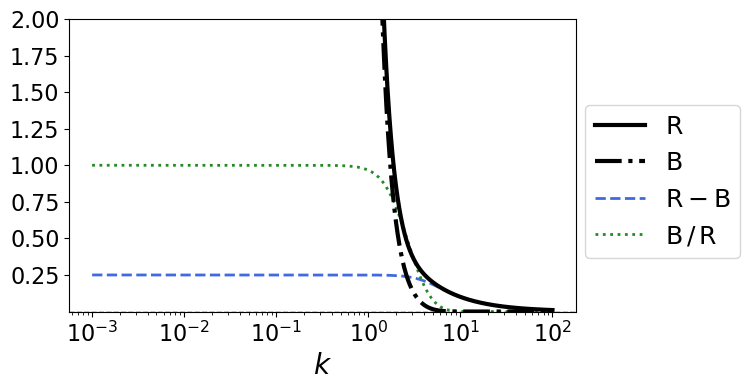

In [2]:
k = np.linspace(1e-3,1e2,num=10000)/(2*np.pi)
plt.close()
plt.figure(figsize=(8,4))
plt.plot(2*np.pi*k,R(k)-B(k),color='royalblue',linestyle='--',linewidth=2)
plt.plot(2*np.pi*k,B(k)/R(k),color='forestgreen',linestyle=':',linewidth=2)
plt.plot(2*np.pi*k,R(k),color='k',linewidth=3,label=r'$\mathsf{R}$')
plt.plot(2*np.pi*k,B(k),color='k',linestyle='-.',linewidth=3,label=r'$\mathsf{B}$')
plt.plot(2*np.pi*k,1e20+0*k,color='royalblue',linestyle='--',linewidth=2,label=r'$\mathsf{R}-\mathsf{B}$')
plt.plot(2*np.pi*k,1e20+0*k,color='forestgreen',linestyle=':',linewidth=2,label=r'$\mathsf{B}\,/\,\mathsf{R}$')
plt.axhline(y=0,color='k',linestyle='--',linewidth=1)
plt.xscale('log')
plt.xlabel(r'$k$',fontsize=20)
plt.ylim(1e-5,2e0)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(bbox_to_anchor=(1.35,0.75),fontsize=18)
plt.tight_layout()
plt.savefig('fig2',bbox_inches='tight')
plt.show()
plt.close()

The main point of this plot is that, while $\mathsf{R}$ and $\mathsf{B}$ are singular in the limit $k\to 0$, their difference and quotient are well-behaved. 

Next we plot the (real part of) the eigenvalues $\{\lambda_+,\lambda_-\}$ of the matrix $\mathsf{A}$:

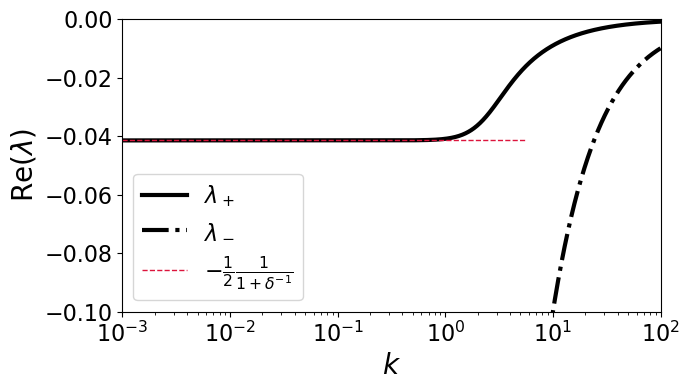

In [3]:
k = np.linspace(1e-3,1e2,num=10000)/(2*np.pi)
Lp = Lamda_p(k,0*k,0).real
Lm = Lamda_m(k,0*k,0).real

plt.figure(figsize=(7,4))
plt.plot(2*np.pi*k,Lp,color='k',linewidth=3,label=r'$\lambda_+$')
plt.plot(2*np.pi*k,Lm,color='k',linestyle='-.',linewidth=3,label=r'$\lambda_-$')
plt.xlabel(r'$k$',fontsize=20)
plt.axhline(y=-p.delta/(p.delta+1)/2,color='crimson',xmax=0.75,linestyle='--',linewidth=1,label=r'$-\frac{1}{2}\frac{1}{1+ {\delta^{-1}}}$')
plt.ylabel(r'$\mathrm{Re}(\lambda)$',fontsize=20)
plt.xscale('log')
plt.ylim(-1e-1,0)
plt.xlim(1e-3,1e2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower left',fontsize=16)
plt.tight_layout()
plt.savefig('fig3',bbox_inches='tight')
plt.show()
plt.close()

The main points here are that both eigenvalues are negative (implies steady solutions are stable) and the larger one $\lambda_-$ remains bounded as $k\to 0$.

(The limiting value $\lambda_+\to -\frac{1}{2}\frac{\delta}{\delta+1}$ as $k\to 0$ is derived in the algebra.py file)

Next we plot the (normalized) eigenvectors $\pmb{\varphi}_+$ and $\pmb{\varphi}_-$ of the matrix $\mathsf{A}$. (These vectors have components that influence $\widehat{h}$ and $\widehat{s}$).

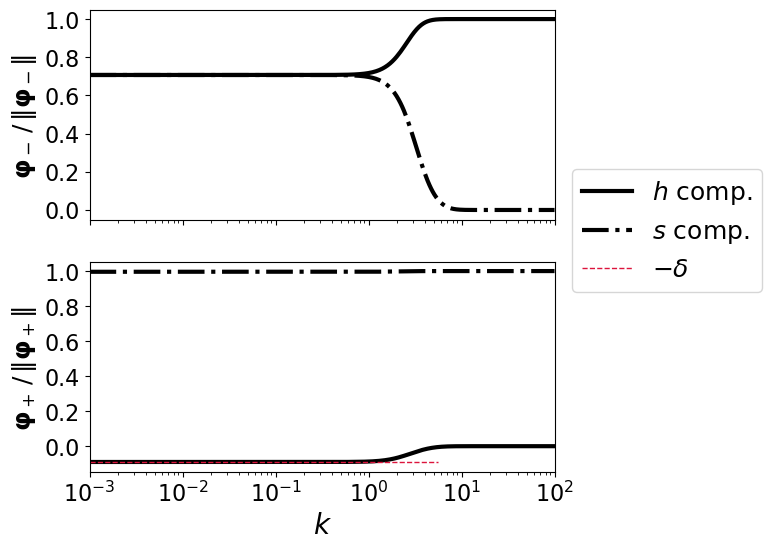

In [4]:
k = np.linspace(1e-3,1e2,num=1000)/(2*np.pi)
R_ = R(k)
B_ = B(k)
chi = (1-p.delta)*R_
mu = np.sqrt(4*p.delta*(B_)**2 + chi**2)

vmh = (R_*(1-p.delta) + mu)/(2*B_)
vph = (R_*(1-p.delta) - mu)/(2*B_)

vps = 1/np.sqrt(1+vph**2)
vms = 1/np.sqrt(1+vmh**2)

vph = vph/np.sqrt(1+vph**2)
vmh = vmh/np.sqrt(1+vmh**2)

plt.close()
plt.figure(figsize=(6,6))
plt.subplot(211)
plt.plot(2*np.pi*k,vmh,color='k',linewidth=3,label=r'$h$')
plt.plot(2*np.pi*k,vms,color='k',linestyle='-.',linewidth=3,label=r'$s$')
plt.xscale('log')
plt.xlim(1e-3,1e2)
plt.yticks(fontsize=16)
plt.gca().xaxis.set_ticklabels([])
plt.ylabel(r'$\mathbf{\varphi}_-\,/\, \Vert\mathbf{\varphi}_-\Vert $ ',fontsize=18)

plt.subplot(212)
plt.plot(2*np.pi*k,vph,color='k',linewidth=3,label=r'$h$ comp.')
plt.plot(2*np.pi*k,vps,color='k',linestyle='-.',linewidth=3,label=r'$s$ comp.')
plt.axhline(y=-p.delta,color='crimson',xmax=0.75,linestyle='--',linewidth=1,label=r'$-\delta$')
plt.xlabel(r'$k$',fontsize=20)
plt.ylabel(r'$\mathbf{\varphi}_+\,/\, \Vert\mathbf{\varphi}_+\Vert $ ',fontsize=18)
plt.xscale('log')
plt.xlim(1e-3,1e2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(1.01,1.5),fontsize=18)
plt.savefig('fig4',bbox_inches='tight')
plt.show()
plt.close()

Here, the main points are that the eigenvector $\pmb{\varphi}_+$ corresponding to the larger eigenvalue $\lambda_+$ approaches
$[-\delta,1]^T$, which serves to drive the solution towards the perfect flotations condition $h=-\delta s$
in the limit $k\to 0$. In the short-wavelength limit ($k\gg 1$), the eigenvectors approach $[1,0]^T$ and $[0,1]^T$, meaning that the upper and lower elevations cease to be coupled. Finally, the long-wavelength limit of the other eigenvector $\pmb{\varphi}_-\to [1,1]^T$
allows for deviation from perfect flotation, although this is not a very strong effect because the corresponding eigenvalue $\lambda_-$ becomes very negative (see previous plot).

Next we will plot the solution kernels $\mathsf{K}_h(k,t)$ and $\mathsf{K}_s(k,t)$ against $t$ and $k$.
(We actually plot $-\mathsf{K}_h/\delta$ because its range is $[0,1]$--see the notes).

In [5]:
k0 = np.linspace(1e-3,1e2,num=1000)/(2*np.pi)
t0 = np.linspace(0,1e2,num=1000)
t,k = np.meshgrid(t0,k0)
Kh0 = ker_h(t,k,0*k,0).real
Ks0 = ker_s(t,k,0*k,0).real

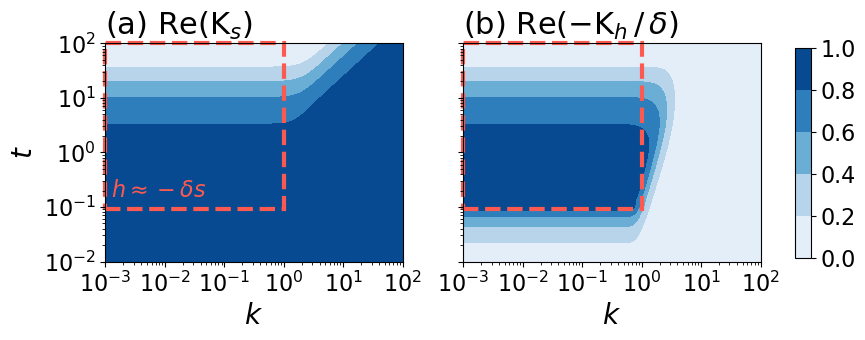

In [6]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patches as patches

levels=np.linspace(0,1,num=6)

box1 = patches.Rectangle((2*np.pi*1.6e-4, 0.9e-1), 1, 1e2, linewidth=3, linestyle='--',edgecolor='xkcd:coral', facecolor='none')
box2 = patches.Rectangle((2*np.pi*1.6e-4, 0.9e-1), 1, 1e2, linewidth=3, linestyle='--', edgecolor='xkcd:coral', facecolor='none')

# Add the patch to the Axes

plt.close()
fig = plt.figure(figsize=(8,3.5))
plt.subplot(121)
plt.title(r'(a) $\mathrm{Re}(\mathsf{K}_s)$',fontsize=22,loc='left')
plt.contourf(2*np.pi*k0,t0,Ks0.T,cmap='Blues',vmin=0,vmax=1,levels=levels)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel(r'$t$',fontsize=20)
plt.xlabel(r'$k$',fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.annotate(xy=(2*np.pi*2e-4, 1.5e-1),text=r'$h\approx-\delta s$',fontsize=16,color='xkcd:coral')
plt.ylim(1e-2,1e2)
patch1 = plt.gca().add_patch(box1)
patch1.set_clip_on(False)

plt.subplot(122)
plt.title(r'(b) $\mathrm{Re}(-\mathsf{K}_h\,/\,\delta)$',loc='left',fontsize=22)
p1 = plt.contourf(2*np.pi*k0,t0,-Kh0.T/p.delta,cmap='Blues',vmin=0,vmax=1,levels=levels)
plt.xticks(fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.gca().yaxis.set_ticklabels([])
plt.xlabel(r'$k$',fontsize=20)
plt.ylim(1e-2,1e2)
patch2 = plt.gca().add_patch(box2)
patch2.set_clip_on(False)


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.25, 0.02, 0.6])
cbar = fig.colorbar(p1,cax=cbar_ax,orientation='vertical',ticks=levels)
cbar.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig('fig5',bbox_inches='tight')
plt.show()
plt.close()

From the solution formulas in the introductory paragraph, it follows that perfect flotation ($h=-\delta s$)
arises when $\mathsf{K}_h = -\delta \mathsf{K}_s$. The region that this is approximately satisfied for is shown by the dashed box in the above figure, roughly corresponding to $(k,t)\in (0,1)\times (10^{-1},\infty)$. Therefore,
deviation from perfect flotation occurs on fast timescales (relative to the relaxtion time) and short
wavelengths.

Here, derive a free-space Green's function, or fundamental solution, in the limit of 
no background advection $\alpha\to 0$ for the case of a line source melting (or freezing) perturbation.
We compute steady solutions via $[\widehat{h}_e,\widehat{s}_e]^\mathrm{T}=-\mathsf{A}^{-1}\boldsymbol{b}$ 
in the limit $\alpha\to 0$ to find
\begin{align}
&\widehat{h}_e =\widehat{G}\,\widehat{m}.
\end{align}
where
\begin{align}
\widehat{G} \equiv 
 -\frac{\mathsf{B}}{\mathsf{R}^2-\mathsf{B}^2} =-[k^2 \mathrm{coth}(k) \mathrm{csch}(k) + k \mathrm{csch}(k)]. 
\end{align}
Restricting the problem to one horizontal dimension (i.e., $k=|k_x|$), we can use the convolution theorem to
find the steady surface elevation via 
\begin{align}
h_\mathrm{e}(x) = \int_{-\infty}^{+\infty} G(x-\tilde{x}) m(\tilde{x}) \;\mathrm{d}\tilde{x},
\end{align}
where the free-space Green's function (or fundamental solution) is 
\begin{align}
G(x) = \frac{\pi}{4}\mathrm{sech}^2\left(\frac{\pi x}{2}\right)\left[\pi x \, \mathrm{tanh}\left(\frac{\pi x}{2}\right)-3 \right], 
\end{align}
which corresponds to the case where the melt rate is a line source in two horizontal dimensions.

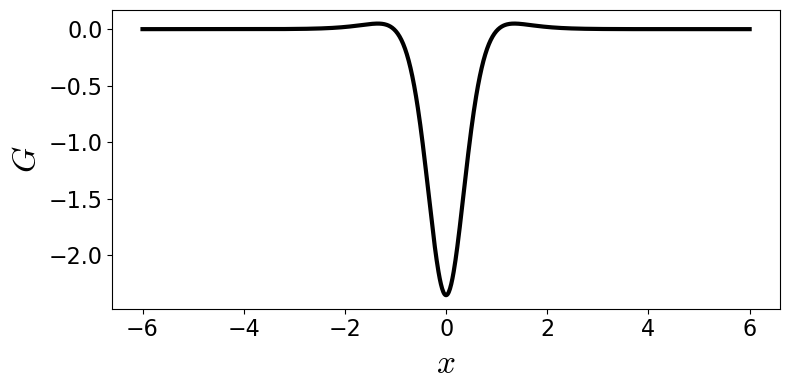

In [7]:
# define parameters
L = 6                               # half-length/width of domain for plotting
x = np.linspace(-L,L,1000)          # spatial array

# 1. Free-space Green's function (fundamental solution) for a line source (i.e., no y dependence)
G = (1./4.)*np.pi *(1/np.cosh((np.pi*x)/2.)**2) *(-3+np.pi*x *np.tanh((np.pi* x)/2.0))

plt.figure(figsize=(8,4))
plt.plot(x,G,'k',linewidth=3)
plt.ylabel(r'$G$',fontsize=24,math_fontfamily='cm')
plt.xlabel(r'$x$',fontsize=24,math_fontfamily='cm')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('fig6')
plt.show()
plt.close()